<a href="https://colab.research.google.com/github/SLokesh1810/mental_health_detector/blob/main/PHQ9_DepressionDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MENTAL HEALTH DETECTOR**
  **Objective:** To detect mental state of a preson with a finite number of questions. The main motive of the model is to make them as optimal as we can, i.e, to have the least number of questions to prediction predict the appropriate mental state.

  For this, we use a **PHQ-9 (Patient Health Questionnaire)** detection system, which is basic model prepared to check the mental state of a patient. It consists of 9 questions to classify between 5 depression i.e,

1.   No depression (0-4)
2.   Mild depression (5-9)
3.   Moderate depression (10-14)
4.   Moderately severe (15-19)
5.   Severe depression (20-27)


## **IMPORTING DATASET**

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/content/drive/MyDrive/CSV files/PHQ9_Dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column                                                                                                                                                                     Non-Null Count  Dtype 
---  ------                                                                                                                                                                     --------------  ----- 
 0   Age                                                                                                                                                                        400 non-null    int64 
 1   Gender                                                                                                                                                                     400 non-null    object
 2   Little interest or pleasure in doing things?                                                  

In [49]:
data.head()

,Age,Gender,Little interest or pleasure in doing things?,"Feeling down, depressed, or hopeless?","Trouble falling or staying asleep, or sleeping too much?",Feeling tired or having little energy?,Poor appetite or overeating?,Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,"Trouble concentrating on things, such as reading the newspaper or watching television?",Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",PHQ-9 Total Score,Depression Level
0,22,Male,Not at all,Several days,Not at all,Several days,Not at all,More than half the days,More than half the days,Several days,Not at all,7,Mild
1,25,Male,Several days,Nearly every day,More than half the days,Several days,Several days,More than half the days,Nearly every day,Nearly every day,Nearly every day,19,Moderately Severe
2,25,Male,Nearly every day,Several days,Nearly every day,Nearly every day,More than half the days,Nearly every day,More than half the days,Nearly every day,Not at all,20,Severe
3,26,Male,Nearly every day,Not at all,Nearly every day,Nearly every day,More than half the days,Nearly every day,Not at all,Not at all,Nearly every day,17,Moderately Severe
4,19,Male,More than half the days,Several days,More than half the days,More than half the days,Nearly every day,Several days,Nearly every day,Nearly every day,Nearly every day,20,Severe


In [50]:
ageDescribe = data['Age'].describe()

print(ageDescribe)

# Dropping the 'Age' column beacuse it is ranged btw 18-26 but we this model to predict for all age category that also lies outside this range
data.drop('Age',inplace=True,axis=1)
data

count    400.000000
mean      22.037500
std        2.589954
min       18.000000
25%       20.000000
50%       22.000000
75%       24.000000
max       26.000000
Name: Age, dtype: float64


,Gender,Little interest or pleasure in doing things?,"Feeling down, depressed, or hopeless?","Trouble falling or staying asleep, or sleeping too much?",Feeling tired or having little energy?,Poor appetite or overeating?,Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,"Trouble concentrating on things, such as reading the newspaper or watching television?",Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",PHQ-9 Total Score,Depression Level
0,Male,Not at all,Several days,Not at all,Several days,Not at all,More than half the days,More than half the days,Several days,Not at all,7,Mild
1,Male,Several days,Nearly every day,More than half the days,Several days,Several days,More than half the days,Nearly every day,Nearly every day,Nearly every day,19,Moderately Severe
2,Male,Nearly every day,Several days,Nearly every day,Nearly every day,More than half the days,Nearly every day,More than half the days,Nearly every day,Not at all,20,Severe
3,Male,Nearly every day,Not at all,Nearly every day,Nearly every day,More than half the days,Nearly every day,Not at all,Not at all,Nearly every day,17,Moderately Severe
4,Male,More than half the days,Several days,More than half the days,More than half the days,Nearly every day,Several days,Nearly every day,Nearly every day,Nearly every day,20,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...
395,Female,Several days,More than half the days,More than half the days,Nearly every day,Nearly every day,More than half the days,Nearly every day,More than half the days,Several days,19,Moderately Severe
396,Male,Several days,More than half the days,Nearly every day,Several days,Nearly every day,Not at all,Several days,Nearly every day,More than half the days,16,Moderately Severe
397,Female,Several days,Not at all,More than half the days,More than half the days,More than half the days,Not at all,More than half the days,More than half the days,More than half the days,13,Moderate
398,Male,Nearly every day,More than half the days,Nearly every day,More than half the days,More than half the days,More than half the days,Several days,Not at all,Nearly every day,18,Moderately Severe


## **DATA PREPROCESSING**

In [52]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# Catergories column names
que_cols = [
    'Little interest or pleasure in doing things?',
    'Feeling down, depressed, or hopeless?',
    'Trouble falling or staying asleep, or sleeping too much?',
    'Feeling tired or having little energy?',
    'Poor appetite or overeating?',
    'Feeling bad about yourself — or that you are a failure or have let yourself or your family down?',
    'Trouble concentrating on things, such as reading the newspaper or watching television?',
    'Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?',
    'Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?'
]

gen_col = ['Gender']
dep_col = ['Depression Level']

# Category column values
que_vals = ['Not at all','Several days','More than half the days','Nearly every day']
dep_vals = ['Minimal','Mild','Moderate','Moderately Severe','Severe']

# Encoders
que_encoder = OrdinalEncoder(categories=[que_vals]*len(que_cols))
gen_encoder = OneHotEncoder(sparse_output=False)
dep_encoder = OrdinalEncoder(categories=[dep_vals])

# Applying preprocessing to data
preprocessor = ColumnTransformer(
    transformers=[
        ('encoded_questions', que_encoder, que_cols),
        ('encoded_gender', gen_encoder, gen_col),
        ('encoded_dep_scale', dep_encoder, dep_col)
    ]
)

transformed_data = preprocessor.fit_transform(data)

feature_cols = preprocessor.get_feature_names_out()

transformed_data = pd.DataFrame(transformed_data,columns=feature_cols)

In [53]:
transformed_data

,encoded_questions__Little interest or pleasure in doing things?,"encoded_questions__Feeling down, depressed, or hopeless?","encoded_questions__Trouble falling or staying asleep, or sleeping too much?",encoded_questions__Feeling tired or having little energy?,encoded_questions__Poor appetite or overeating?,encoded_questions__Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,"encoded_questions__Trouble concentrating on things, such as reading the newspaper or watching television?",encoded_questions__Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,"encoded_questions__Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",encoded_gender__Gender_Female,encoded_gender__Gender_Male,encoded_dep_scale__Depression Level
0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0
1,1.0,3.0,2.0,1.0,1.0,2.0,3.0,3.0,3.0,0.0,1.0,3.0
2,3.0,1.0,3.0,3.0,2.0,3.0,2.0,3.0,0.0,0.0,1.0,4.0
3,3.0,0.0,3.0,3.0,2.0,3.0,0.0,0.0,3.0,0.0,1.0,3.0
4,2.0,1.0,2.0,2.0,3.0,1.0,3.0,3.0,3.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,2.0,2.0,3.0,3.0,2.0,3.0,2.0,1.0,1.0,0.0,3.0
396,1.0,2.0,3.0,1.0,3.0,0.0,1.0,3.0,2.0,0.0,1.0,3.0
397,1.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,2.0
398,3.0,2.0,3.0,2.0,2.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0


## **DATA VISUALIZATION**

<Axes: xlabel='Depression Level', ylabel='Count'>

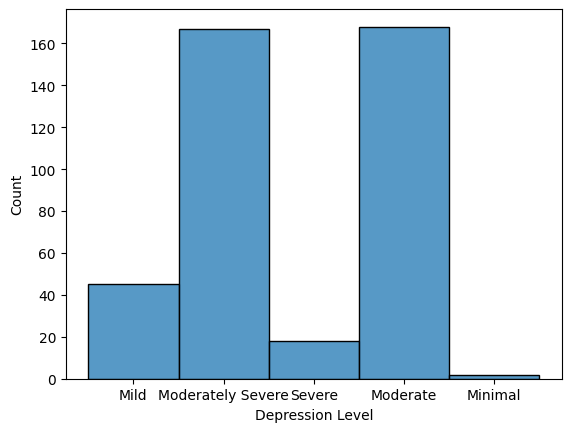

In [54]:
sns.histplot(data['Depression Level'])

In [65]:
corrMat = transformed_data.corr()['encoded_dep_scale__Depression Level']
sorted_corr_mat = corrMat.sort_values()
sorted_corr_mat

,encoded_dep_scale__Depression Level
encoded_gender__Gender_Male,-0.029242
encoded_gender__Gender_Female,0.029242
encoded_questions__Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,0.283332
encoded_questions__Feeling tired or having little energy?,0.296656
"encoded_questions__Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",0.314790
encoded_questions__Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,0.324681
"encoded_questions__Trouble concentrating on things, such as reading the newspaper or watching television?",0.325786
encoded_questions__Little interest or pleasure in doing things?,0.327275
"encoded_questions__Feeling down, depressed, or hopeless?",0.328802
encoded_questions__Poor appetite or overeating?,0.328892
